In [ ]:
import numpy as np
import time


def _mean_squared_error(y, pred):
    return 0.5 * np.mean((y - pred) ** 2)


def _mean_abs_error(y, pred):
    return np.mean(np.abs(y, pred))


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def _fourier(x):
    return np.sin(x)


def _hardlimit(x):
    return (x >= 0).astype(int)


def _identity(x):
    return x


def getActivation(name):
    return {
        'sigmoid': _sigmoid,
        'fourier': _fourier,
        'hardlimit': _hardlimit
    }[name]


def getLoss(name):
    return {
        'mse': _mean_squared_error,
        'mae': _mean_abs_error
    }[name]


class ELM:
    def __init__(self, num_input_nodes, num_hidden_units, num_out_units, activation='sigmoid',
                 loss='mse', beta_init=None, w_init=None, bias_init=None):
        self._num_input_nodes = num_input_nodes
        self._num_hidden_units = num_hidden_units
        self._num_out_units = num_out_units

        self._activation = getActivation(activation)
        self._loss = getLoss(loss)

        if isinstance(beta_init, np.ndarray):
            self._beta = beta_init
        else:
            self._beta = np.random.uniform(-1., 1., size=(self._num_hidden_units, self._num_out_units))

        if isinstance(w_init, np.ndarray):
            self._w = w_init
        else:
            self._w = np.random.uniform(-1, 1, size=(self._num_input_nodes, self._num_hidden_units))

        if isinstance(bias_init, np.ndarray):
            self._bias = bias_init
        else:
            self._bias = np.zeros(shape=(self._num_hidden_units,))

        print('Bias shape:', self._bias.shape)
        print('W shape:', self._w.shape)
        print('Beta shape:', self._beta.shape)

    def fit(self, X, Y, display_time=False):
        H = self._activation(X.dot(self._w) + self._bias)

        # Moore–Penrose pseudo inverse
        if display_time:
            start = time.time()
        H_pinv = np.linalg.pinv(H)
        if display_time:
            stop = time.time()
            print(f'Train time: {stop-start}')

        self._beta = H_pinv.dot(Y)

        # print('Fit Beta shape:', self._beta.shape)

    def __call__(self, X):
        H = self._activation(X.dot(self._w) + self._bias)
        return H.dot(self._beta)

    def evaluate(self, X, Y):
        pred = self(X)

        # Loss (base on model setting)
        loss = self._loss(Y, pred)

        # Accuracy
        acc = np.sum(np.argmax(pred, axis=-1) == np.argmax(Y, axis=-1)) / len(Y)

        # Unweighted Average Recall
        # TODO

        return loss, acc

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [2]:
dj = pd.read_csv("/content/drive/MyDrive/combined-price.csv")
dj.head()

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price,Label
0,01-Oct-08,46.65,46.80,46.30,46.45,46.464286,3500,14,162625,3500,100.0,0.5,-0.2,0.000000,46.6500,0.000000,46.800,0.000000,46.300000,0.000000,46.450000,0
1,03-Oct-08,44.15,44.15,44.15,44.15,44.150000,100,1,4415,100,100.0,0.0,0.0,-0.053591,45.4000,-0.056624,45.475,-0.046436,45.225000,-0.049516,45.300000,0
2,06-Oct-08,41.95,41.95,41.95,41.95,41.950000,6000,2,251700,6000,100.0,0.0,0.0,-0.049830,44.2500,-0.049830,44.300,-0.049830,44.133333,-0.049830,44.183333,0
3,10-Oct-08,39.90,39.90,39.90,39.90,39.900000,100,1,3990,100,100.0,0.0,0.0,-0.048868,43.1625,-0.048868,43.200,-0.048868,43.075000,-0.048868,43.112500,0
4,13-Oct-08,37.95,37.95,37.95,37.95,37.950000,400,3,15180,400,100.0,0.0,0.0,-0.048872,42.1200,-0.048872,42.150,-0.048872,42.050000,-0.048872,42.080000,0


In [3]:
dj_y = dj["Label"]
print(dj_y)

0       0
1       0
2       0
3       0
4       0
       ..
3065    0
3066    0
3067    0
3068    0
3069    0
Name: Label, Length: 3070, dtype: int64


In [4]:
dj = dj.drop(["Label"], axis=1)

In [5]:
dj = dj.drop(["Date"], axis=1)

In [6]:
dj=(dj - dj.min())/(dj.max()-dj.min())
dj.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price
0,0.032776,0.032846,0.032574,0.032598,0.032666,0.000680,0.000979,0.000703,0.001966,1.0,0.003761,0.556371,0.049486,0.039086,0.024506,0.038820,0.062599,0.039043,0.023949,0.038736
1,0.031003,0.030967,0.031047,0.030967,0.031023,0.000019,0.000000,0.000019,0.000056,1.0,0.000000,0.557235,0.046567,0.038027,0.022973,0.037708,0.059399,0.038126,0.022632,0.037766
2,0.029442,0.029407,0.029484,0.029407,0.029461,0.001166,0.000075,0.001088,0.003371,1.0,0.000000,0.557235,0.046772,0.037052,0.023157,0.036721,0.059165,0.037194,0.022623,0.036824
3,0.027988,0.027954,0.028027,0.027954,0.028006,0.000019,0.000000,0.000017,0.000056,1.0,0.000000,0.557235,0.046824,0.036130,0.023183,0.035797,0.059231,0.036291,0.022649,0.035920
4,0.026604,0.026572,0.026642,0.026572,0.026621,0.000078,0.000151,0.000066,0.000225,1.0,0.000000,0.557235,0.046824,0.035246,0.023183,0.034916,0.059231,0.035417,0.022649,0.035049


In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(dj, dj_y, test_size=0.33, random_state=42)

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_train,y_train)

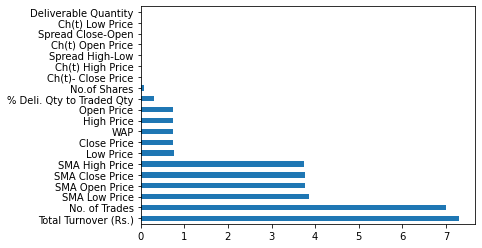

In [12]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_train.columns)
#concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(20,'Score'))  #print 10 best features
feat_importances = pd.Series(fit.scores_, index=df_train.columns)
import matplotlib.pyplot as plt
%matplotlib inline
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
print(df_train[y_train==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
2750    0.493881    0.552615  ...            0.026327         0.528906
49      0.018375    0.018348  ...            0.024477         0.021791
1563    0.012479    0.012456  ...            0.022631         0.012193
1780    0.358128    0.395475  ...            0.024835         0.559995
48      0.016707    0.018064  ...            0.024433         0.021803
...          ...         ...  ...                 ...              ...
2135    0.020255    0.021715  ...            0.024039         0.028751
1482    0.008123    0.008685  ...            0.026594         0.013108
1238    0.035863    0.040077  ...            0.024214         0.047152
1638    0.046504    0.046458  ...            0.023418         0.052365
1294    0.019900    0.020085  ...            0.022658         0.022728

[887 rows x 20 columns]>


In [ ]:
print(df_train[y_train==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1216    0.037636    0.039971  ...            0.024317         0.031848
858     0.025576    0.026111  ...            0.024759         0.019394
1601    0.026923    0.026891  ...            0.025258         0.024450
2584    0.389876    0.393136  ...            0.024191         0.464996
2178    0.001646    0.001631  ...            0.024438         0.001206
...          ...         ...  ...                 ...              ...
466     0.038771    0.039652  ...            0.023712         0.029501
2169    0.001362    0.001347  ...            0.024406         0.001036
1095    0.025185    0.025189  ...            0.023074         0.027161
1130    0.024511    0.025331  ...            0.025260         0.025910
860     0.026711    0.026749  ...            0.023001         0.019715

[1169 rows x 20 columns]>


In [ ]:
print(df_test[y_test==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1644    0.036927    0.037206  ...            0.024081         0.048890
240     0.014636    0.014612  ...            0.025274         0.018291
1642    0.037281    0.039014  ...            0.022661         0.050373
1052    0.010110    0.010088  ...            0.024058         0.011624
257     0.011706    0.011967  ...            0.022682         0.017589
...          ...         ...  ...                 ...              ...
3059    0.282750    0.282539  ...            0.024245         0.339870
969     0.030825    0.030790  ...            0.024448         0.035823
1809    0.150083    0.149965  ...            0.025273         0.346059
2095    0.031570    0.031534  ...            0.025253         0.033692
530     0.001986    0.002410  ...            0.023488         0.018283

[419 rows x 20 columns]>


In [ ]:
print(df_test[y_test==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1446    0.008549    0.008529  ...            0.024775         0.014006
2595    0.409351    0.409052  ...            0.024433         0.467851
194     0.033982    0.034335  ...            0.024261         0.038907
1423    0.009060    0.009805  ...            0.024351         0.014785
2005    0.146891    0.146775  ...            0.022621         0.295650
...          ...         ...  ...                 ...              ...
1628    0.039906    0.039864  ...            0.025181         0.033872
856     0.024937    0.025508  ...            0.024944         0.019067
166     0.043489    0.043445  ...            0.024328         0.038354
59      0.017630    0.017603  ...            0.024570         0.019923
611     0.003774    0.003757  ...            0.025255         0.003648

[595 rows x 20 columns]>


In [ ]:
y_train = y_train.values
print(y_train)
y_train1 = []
for i in y_train:
  if i ==0:
    y_train1.append([1,0])
  else:
    y_train1.append([0,1])
print(y_train1)

[0 0 0 ... 1 0 1]
[[1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1

In [ ]:
y_test = y_test.values
print(y_test)
y_test1 = []
for i in y_test:
  if i ==0:
    y_test1.append([1,0])
  else:
    y_test1.append([0,1])
print(y_test1)

[1 1 0 ... 1 1 0]
[[0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0

In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.357236385345459
train loss: 0.037224
train acc: 0.922665


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 2.014529
val acc: 0.833333


In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.8361740112304688
train loss: 0.037378
train acc: 0.923638


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 2.192534
val acc: 0.840237


In [ ]:
tr_pred = model(df_train.values)
print(tr_pred)

[[ 1.00017585e+00 -1.75852168e-04]
 [ 2.24414488e-01  7.75585315e-01]
 [ 4.14822214e-01  5.85177772e-01]
 ...
 [ 3.61902919e-01  6.38097053e-01]
 [ 6.52202157e-01  3.47797756e-01]
 [ 1.05720236e-01  8.94279732e-01]]


In [ ]:
pred = model(df_test.values)

In [ ]:
print(pred)

[[ 0.22861917  0.77138087]
 [ 0.21097179  0.7890284 ]
 [ 0.97033783  0.02966213]
 ...
 [ 0.22773038  0.77226959]
 [ 0.18440935  0.81559063]
 [ 2.49952061 -1.49951848]]


In [ ]:
y_pred = np.argmax(pred, axis=-1)

In [ ]:
print(y_pred)

[1 1 0 ... 1 1 0]


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
score = accuracy_score(y_test, y_pred)
print(score)
report = classification_report(y_test, y_pred)
print(report)

[[337  82]
 [ 80 515]]
0.8402366863905325
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       419
           1       0.86      0.87      0.86       595

    accuracy                           0.84      1014
   macro avg       0.84      0.83      0.84      1014
weighted avg       0.84      0.84      0.84      1014



[0.         0.19570406 1.        ]
[0.         0.86554622 1.        ]


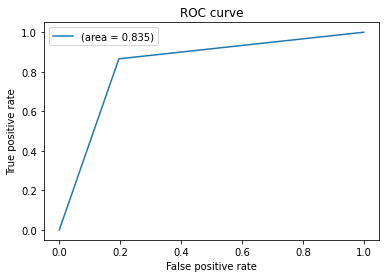

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
tp = tpr_keras
fp = fpr_keras
print(fpr_keras)
print(tpr_keras)



auc_rf = auc(fp, tp)
plt.plot(fp,tp,label="(area = {:.3f})".format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.6703153787796684


In [ ]:
num_classes = 2
num_hidden_layers = 256
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (256,)
W shape: (20, 256)
Beta shape: (256, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.10410165786743164
train loss: 0.054831
train acc: 0.874514


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.390418
val acc: 0.806706


In [ ]:
num_classes = 2
num_hidden_layers = 128
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (128,)
W shape: (20, 128)
Beta shape: (128, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.04391980171203613
train loss: 0.075205
train acc: 0.815175


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.093932
val acc: 0.789941


In [ ]:
num_classes = 2
num_hidden_layers = 64
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (64,)
W shape: (20, 64)
Beta shape: (64, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.026721477508544922
train loss: 0.095807
train acc: 0.717412


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.102541
val acc: 0.723866


In [ ]:
num_classes = 2
num_hidden_layers = 32
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (32,)
W shape: (20, 32)
Beta shape: (32, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.004770994186401367
train loss: 0.106113
train acc: 0.636187


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.104333
val acc: 0.662722


In [ ]:
num_classes = 2
num_hidden_layers = 1024
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (1024,)
W shape: (20, 1024)
Beta shape: (1024, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 1.7189834117889404
train loss: 0.019209
train acc: 0.965467


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 907.859641
val acc: 0.770217


In [13]:
dj = pd.read_csv("/content/drive/MyDrive/combined-volume.csv")
dj.head()

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price,Label
0,01-Oct-08,46.65,46.80,46.30,46.45,46.464286,3500,14,162625,3500,100.0,0.5,-0.2,0.000000,46.6500,0.000000,46.800,0.000000,46.300000,0.000000,46.450000,0
1,03-Oct-08,44.15,44.15,44.15,44.15,44.150000,100,1,4415,100,100.0,0.0,0.0,-0.053591,45.4000,-0.056624,45.475,-0.046436,45.225000,-0.049516,45.300000,0
2,06-Oct-08,41.95,41.95,41.95,41.95,41.950000,6000,2,251700,6000,100.0,0.0,0.0,-0.049830,44.2500,-0.049830,44.300,-0.049830,44.133333,-0.049830,44.183333,0
3,10-Oct-08,39.90,39.90,39.90,39.90,39.900000,100,1,3990,100,100.0,0.0,0.0,-0.048868,43.1625,-0.048868,43.200,-0.048868,43.075000,-0.048868,43.112500,0
4,13-Oct-08,37.95,37.95,37.95,37.95,37.950000,400,3,15180,400,100.0,0.0,0.0,-0.048872,42.1200,-0.048872,42.150,-0.048872,42.050000,-0.048872,42.080000,0


In [14]:
dj_y = dj["Label"]
print(dj_y)

0       0
1       0
2       0
3       0
4       0
       ..
4006    0
4007    0
4008    0
4009    0
4010    0
Name: Label, Length: 4011, dtype: int64


In [15]:
dj = dj.drop(["Label", "Date"], axis=1)

In [16]:
dj=(dj - dj.min())/(dj.max()-dj.min())
dj.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price
0,0.032776,0.032846,0.032574,0.032598,0.032666,0.000680,0.000979,0.000910,0.001966,0.009488,0.004013,0.547776,0.054206,0.039086,0.027000,0.038820,0.068493,0.039043,0.026535,0.038736
1,0.031003,0.030967,0.031047,0.030967,0.031023,0.000019,0.000000,0.000025,0.000056,0.009488,0.000000,0.548657,0.051301,0.038027,0.025471,0.037708,0.065313,0.038126,0.025221,0.037766
2,0.029442,0.029407,0.029484,0.029407,0.029461,0.001166,0.000075,0.001408,0.003371,0.009488,0.000000,0.548657,0.051505,0.037052,0.025655,0.036721,0.065080,0.037194,0.025213,0.036824
3,0.027988,0.027954,0.028027,0.027954,0.028006,0.000019,0.000000,0.000022,0.000056,0.009488,0.000000,0.548657,0.051557,0.036130,0.025681,0.035797,0.065146,0.036291,0.025238,0.035920
4,0.026604,0.026572,0.026642,0.026572,0.026621,0.000078,0.000151,0.000085,0.000225,0.009488,0.000000,0.548657,0.051557,0.035246,0.025680,0.034916,0.065146,0.035417,0.025238,0.035049


In [17]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(dj, dj_y, test_size=0.33, random_state=42)

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_train,y_train)

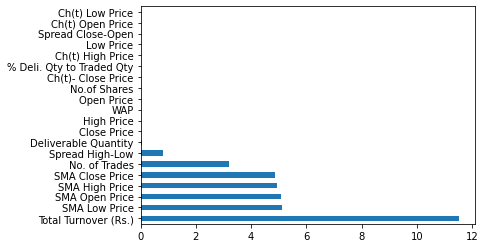

In [19]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_train.columns)
#concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(20,'Score'))  #print 10 best features
feat_importances = pd.Series(fit.scores_, index=df_train.columns)
import matplotlib.pyplot as plt
%matplotlib inline
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
print(df_train[y_train==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1822    0.148345    0.148228  ...            0.026561         0.301787
2978    0.001000    0.000985  ...            0.021875         0.000953
772     0.011458    0.011435  ...            0.027288         0.019579
1284    0.002448    0.002496  ...            0.026196         0.016511
498     0.002980    0.002963  ...            0.025650         0.035724
...          ...         ...  ...                 ...              ...
2135    0.020255    0.021715  ...            0.026624         0.028751
1482    0.008123    0.008685  ...            0.029172         0.013108
1238    0.035863    0.040077  ...            0.026799         0.047152
1638    0.046504    0.046458  ...            0.026005         0.052365
1294    0.019900    0.020085  ...            0.025247         0.022728

[977 rows x 20 columns]>


In [ ]:
print(df_train[y_train==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
328     0.011351    0.011329  ...            0.027080         0.015281
1861    0.116739    0.118062  ...            0.025569         0.161716
2266    0.019297    0.019269  ...            0.027844         0.005091
1940    0.265014    0.264815  ...            0.026657         0.197802
3801    0.157178    0.159181  ...            0.026234         0.211428
...          ...         ...  ...                 ...              ...
1095    0.025185    0.025189  ...            0.025662         0.027161
1130    0.024511    0.025331  ...            0.027842         0.025910
860     0.026711    0.026749  ...            0.025590         0.019715
3507    0.091199    0.092894  ...            0.026897         0.035615
3174    0.006328    0.006310  ...            0.027842         0.005292

[1710 rows x 20 columns]>


In [ ]:
print(df_test[y_test==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
2899    0.000780    0.000879  ...            0.029274         0.000708
1756    0.020219    0.020510  ...            0.027862         0.038109
490     0.032989    0.033697  ...            0.026737         0.041534
2383    0.687844    0.687529  ...            0.026555         0.715855
978     0.033663    0.033626  ...            0.026564         0.036088
...          ...         ...  ...                 ...              ...
1501    0.012132    0.012180  ...            0.027795         0.013100
3711    0.282750    0.293882  ...            0.025884         0.336320
1717    0.031499    0.031463  ...            0.025869         0.041516
3717    0.200809    0.209375  ...            0.026517         0.314841
962     0.030542    0.030506  ...            0.025731         0.035883

[481 rows x 20 columns]>


In [ ]:
print(df_test[y_test==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
325     0.011990    0.011967  ...            0.026216         0.015793
2619    0.267851    0.281830  ...            0.026612         0.104211
2498    0.033699    0.033661  ...            0.027043         0.040956
3245    0.006314    0.006962  ...            0.025343         0.007126
179     0.038665    0.038624  ...            0.025534         0.039052
...          ...         ...  ...                 ...              ...
1965    0.347309    0.356979  ...            0.024678         0.224772
1945    0.281331    0.281121  ...            0.026041         0.203292
168     0.041538    0.041495  ...            0.025729         0.038509
945     0.035118    0.035079  ...            0.025749         0.027544
462     0.039764    0.041424  ...            0.026605         0.029045

[843 rows x 20 columns]>


In [ ]:
y_train = y_train.values
print(y_train)
y_train1 = []
for i in y_train:
  if i ==0:
    y_train1.append([1,0])
  else:
    y_train1.append([0,1])
print(y_train1)

[0 1 1 ... 1 1 1]
[[1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1

In [ ]:
y_test = y_test.values
print(y_test)
y_test1 = []
for i in y_test:
  if i ==0:
    y_test1.append([1,0])
  else:
    y_test1.append([0,1])
print(y_test1)

[1 1 0 ... 0 1 1]
[[0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1

In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.4385716915130615
train loss: 0.045074
train acc: 0.893934


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 1582.394190
val acc: 0.827039


In [ ]:
tr_pred = model(df_train.values)
print(tr_pred)

[[0.77746573 0.22253427]
 [0.92205863 0.07794137]
 [0.04621649 0.9537835 ]
 ...
 [0.12975398 0.87024602]
 [0.04887803 0.95112198]
 [0.29223424 0.70776576]]


In [ ]:
pred = model(df_test.values)

In [ ]:
print(pred)

[[0.68718391 0.31281609]
 [0.53466383 0.46533645]
 [0.33236239 0.66763761]
 ...
 [0.8528017  0.14719831]
 [0.01822433 0.98177567]
 [0.07337249 0.92662753]]


In [ ]:
y_pred = np.argmax(pred, axis=-1)

In [ ]:
print(y_pred)

[0 0 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
score = accuracy_score(y_test, y_pred)
print(score)
report = classification_report(y_test, y_pred)
print(report)

[[340 141]
 [ 88 755]]
0.8270392749244713
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       481
           1       0.84      0.90      0.87       843

    accuracy                           0.83      1324
   macro avg       0.82      0.80      0.81      1324
weighted avg       0.83      0.83      0.82      1324



[0.         0.29313929 1.        ]
[0.         0.89561091 1.        ]


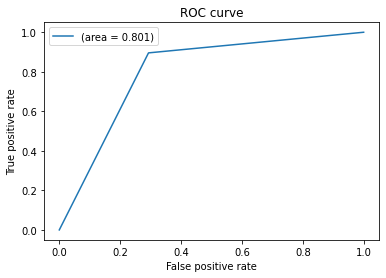

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
tp = tpr_keras
fp = fpr_keras
print(fpr_keras)
print(tpr_keras)



auc_rf = auc(fp, tp)
plt.plot(fp,tp,label="(area = {:.3f})".format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.6170703983429741


In [ ]:
num_classes = 2
num_hidden_layers = 256
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (256,)
W shape: (20, 256)
Beta shape: (256, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.17766785621643066
train loss: 0.059030
train acc: 0.855601


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 23.825570
val acc: 0.818731


In [ ]:
num_classes = 2
num_hidden_layers = 128
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (128,)
W shape: (20, 128)
Beta shape: (128, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.05996084213256836
train loss: 0.075651
train acc: 0.806476


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.219135
val acc: 0.786254


In [ ]:
num_classes = 2
num_hidden_layers = 64
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (64,)
W shape: (20, 64)
Beta shape: (64, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.021610736846923828
train loss: 0.084255
train acc: 0.740975


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.447052
val acc: 0.721299


In [ ]:
num_classes = 2
num_hidden_layers = 32
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (32,)
W shape: (20, 32)
Beta shape: (32, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.014867782592773438
train loss: 0.091650
train acc: 0.711202


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 0.788232
val acc: 0.694864


In [ ]:
num_classes = 2
num_hidden_layers = 1024
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (1024,)
W shape: (20, 1024)
Beta shape: (1024, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 1.9796943664550781
train loss: 0.030196
train acc: 0.933011


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 1146946.926310
val acc: 0.819486


In [ ]:
num_classes = 2
num_hidden_layers = 2056
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (2056,)
W shape: (20, 2056)
Beta shape: (2056, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 11.556114673614502
train loss: 0.008173
train acc: 0.988835


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 9735223927.520134
val acc: 0.697885


In [ ]:
dj = pd.read_csv("/content/drive/MyDrive/Manipulation_combined.csv")
dj.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price,Label
0,9.91,10.11,9.80,9.80,9.957101,3450,32,34352,2100,60.87,0.31,-0.11,0.000000,9.9100,0.000000,10.110000,0.000000,9.800000,0.000000,9.800000,0
1,9.30,10.00,9.30,9.67,9.845920,3615,14,35593,3515,97.23,0.70,0.37,-0.061554,9.6050,-0.010880,10.055000,-0.051020,9.550000,-0.013265,9.735000,0
2,10.40,10.60,9.80,10.00,10.040000,6100,33,61244,5788,94.89,0.80,-0.40,0.118280,9.8700,0.060000,10.236667,0.053763,9.633333,0.034126,9.823333,0
3,10.00,10.50,10.00,10.45,10.388344,3775,39,39216,3775,100.00,0.50,0.45,-0.038462,9.9025,-0.009434,10.302500,0.020408,9.725000,0.045000,9.980000,0
4,10.21,10.60,10.21,10.40,10.532770,946,8,9964,873,92.28,0.39,0.19,0.021000,9.9640,0.009524,10.362000,0.021000,9.822000,-0.004785,10.064000,0


In [ ]:
dj_y = dj["Label"]
print(dj_y)

0       0
1       0
2       0
3       0
4       0
       ..
4930    0
4931    0
4932    0
4933    0
4934    0
Name: Label, Length: 4935, dtype: int64


In [ ]:
dj = dj.drop(["Label"], axis=1)

In [ ]:
dj=(dj - dj.min())/(dj.max()-dj.min())
dj.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price
0,0.006711,0.006834,0.006643,0.006615,0.006749,0.000670,0.002335,0.000148,0.001180,0.005776,0.002332,0.556760,0.054206,0.007938,0.027000,0.008013,0.068493,0.007902,0.026535,0.007808
1,0.006279,0.006756,0.006288,0.006522,0.006670,0.000702,0.000979,0.000154,0.001975,0.009225,0.005265,0.558834,0.050870,0.007680,0.026706,0.007967,0.064999,0.007688,0.026183,0.007753
2,0.007059,0.007182,0.006643,0.006756,0.006808,0.001185,0.002410,0.000265,0.003252,0.009003,0.006017,0.555508,0.060618,0.007904,0.028620,0.008120,0.072176,0.007760,0.027440,0.007828
3,0.006775,0.007111,0.006785,0.007075,0.007055,0.000734,0.002862,0.000169,0.002121,0.009488,0.003761,0.559179,0.052122,0.007932,0.026745,0.008175,0.069891,0.007838,0.027729,0.007960
4,0.006924,0.007182,0.006934,0.007040,0.007157,0.000184,0.000527,0.000043,0.000490,0.008756,0.002933,0.558056,0.055345,0.007984,0.027257,0.008225,0.069932,0.007921,0.026408,0.008031


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(dj, dj_y, test_size=0.33, random_state=42)

In [ ]:
print(df_train[y_train==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
124     0.031180    0.034370  ...            0.027728         0.043448
1867    0.290483    0.292465  ...            0.026639         0.340932
1586    0.157887    0.162726  ...            0.027413         0.188737
1257    0.017417    0.019234  ...            0.027796         0.085444
3406    0.008123    0.008685  ...            0.029172         0.013108
...          ...         ...  ...                 ...              ...
2919    0.022631    0.022637  ...            0.027027         0.020392
3171    0.444184    0.443862  ...            0.023796         0.560365
3444    0.012451    0.012641  ...            0.027827         0.013381
4426    0.015076    0.018348  ...            0.031284         0.007153
466     0.000993    0.000978  ...            0.022949         0.000696

[1253 rows x 20 columns]>


In [ ]:
print(df_train[y_train==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1765    0.281686    0.281511  ...            0.026863         0.234092
2317    0.117626    0.125293  ...            0.026322         0.164423
3567    0.006435    0.006416  ...            0.027046         0.003119
910     0.059629    0.061452  ...            0.027702         0.014343
4036    0.009719    0.009698  ...            0.026476         0.005134
...          ...         ...  ...                 ...              ...
769     0.013338    0.013314  ...            0.025209         0.005998
1685    0.149374    0.171942  ...            0.026878         0.185785
3092    0.403710    0.403770  ...            0.025731         0.471039
3772    0.026711    0.026749  ...            0.025590         0.019715
860     0.035792    0.035894  ...            0.027673         0.008861

[2053 rows x 20 columns]>


In [ ]:
print(df_test[y_test==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
4683    0.010720    0.010698  ...            0.026435         0.012115
151     0.038700    0.039014  ...            0.025826         0.043002
4169    0.015998    0.017284  ...            0.026759         0.021897
296     0.677202    0.707911  ...            0.027757         0.735186
4629    0.002696    0.003034  ...            0.027138         0.029247
...          ...         ...  ...                 ...              ...
4893    0.004008    0.004062  ...            0.024974         0.041632
3459    0.010961    0.010939  ...            0.026280         0.013369
3886    0.030364    0.030790  ...            0.026815         0.035941
2213    0.205420    0.208808  ...            0.026310         0.236493
121     0.031606    0.031570  ...            0.027834         0.043831

[603 rows x 20 columns]>


In [ ]:
print(df_test[y_test==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1972    0.059913    0.059857  ...            0.027061         0.061682
2423    0.320989    0.350741  ...            0.028509         0.223628
1412    0.197545    0.197394  ...            0.026496         0.208173
4209    0.025008    0.024976  ...            0.025271         0.025504
626     0.002582    0.002602  ...            0.026468         0.002398
...          ...         ...  ...                 ...              ...
796     0.009968    0.010301  ...            0.026186         0.006809
368     0.815544    0.814963  ...            0.026124         0.938055
785     0.009968    0.009947  ...            0.025459         0.006556
2036    0.109645    0.109555  ...            0.027402         0.094928
2374    0.214572    0.214409  ...            0.024727         0.176945

[1026 rows x 20 columns]>


In [ ]:
y_train = y_train.values
print(y_train)
y_train1 = []
for i in y_train:
  if i ==0:
    y_train1.append([1,0])
  else:
    y_train1.append([0,1])
print(y_train1)

[1 1 1 ... 1 1 1]
[[0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0

In [ ]:
y_test = y_test.values
print(y_test)
y_test1 = []
for i in y_test:
  if i ==0:
    y_test1.append([1,0])
  else:
    y_test1.append([0,1])
print(y_test1)

[1 0 0 ... 0 0 0]
[[0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1

In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.5097522735595703
train loss: 0.052712
train acc: 0.873866


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 20.174525
val acc: 0.848373


In [ ]:
num_classes = 2
num_hidden_layers = 1024
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (1024,)
W shape: (20, 1024)
Beta shape: (1024, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 2.2285594940185547
train loss: 0.035243
train acc: 0.918028


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 5631.699063
val acc: 0.817066


In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.49089765548706055
train loss: 0.052643
train acc: 0.871446


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 8.713600
val acc: 0.840393


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_train,y_train)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

                        Specs     Score
15             SMA High Price  9.797163
13             SMA Open Price  9.727806
17              SMA Low Price  9.521992
19            SMA Close Price  9.480249
7        Total Turnover (Rs.)  7.718107
6               No. of Trades  3.785646
10            Spread High-Low  0.767516
1                  High Price  0.503539
0                  Open Price  0.458935
2                   Low Price  0.448015
4                         WAP  0.447797
3                 Close Price  0.441170
9   % Deli. Qty to Traded Qty  0.134183
8        Deliverable Quantity  0.044299
14           Ch(t) High Price  0.005810
18         Ch(t)- Close Price  0.005547
11          Spread Close-Open  0.001295
5                No.of Shares  0.000284
16            Ch(t) Low Price  0.000088
12           Ch(t) Open Price  0.000025


[0.06036124 0.06240771 0.05780856 0.05402088 0.06061707 0.02620928
 0.0293226  0.03176297 0.02667942 0.04324475 0.03036287 0.01588575
 0.01496681 0.10539454 0.01808806 0.10976276 0.01745945 0.10868961
 0.02033459 0.10662108]


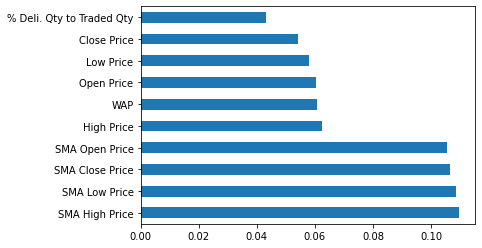

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(df_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
df_train1 = df_train[["SMA High Price","SMA Open Price", "SMA Low Price","SMA Close Price", "Total Turnover (Rs.)","No. of Trades", "Spread High-Low"]]

In [ ]:
df_test1 = df_test[["SMA High Price","SMA Open Price", "SMA Low Price","SMA Close Price", "Total Turnover (Rs.)","No. of Trades", "Spread High-Low"]]

In [ ]:
num_classes = 2
num_hidden_layers = 4096
input_length = 6

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (4096,)
W shape: (6, 4096)
Beta shape: (4096, 2)


In [ ]:
model.fit(df_train1.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train1.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 38.950512647628784
train loss: 0.052710
train acc: 0.865396


In [ ]:
val_loss, val_acc = model.evaluate(df_test1.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 12348279103.654200
val acc: 0.829343


In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 7

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (7, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train1.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train1.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.5088937282562256
train loss: 0.062929
train acc: 0.815487


In [ ]:
val_loss, val_acc = model.evaluate(df_test1.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 7921338.731992
val acc: 0.777778


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Manipulation_Dataset.csv")
print(df.head())

   Open Price  High Price  ...  SMA Close Price  Label
0    0.007028    0.007165  ...         0.008266      0
1    0.006596    0.007087  ...         0.008211      0
2    0.007376    0.007512  ...         0.008286      0
3    0.007092    0.007442  ...         0.008418      0
4    0.007241    0.007512  ...         0.008489      0

[5 rows x 21 columns]


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [ ]:
df_train.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price,Label
1765,0.281915,0.281751,0.279830,0.281219,0.281505,9.368885e-03,0.096181,8.261172e-02,1.299251e-02,0.004552,0.026702,-0.006829,-0.000215,0.234585,-0.000170,0.238120,0.001330,0.230509,0.000337,0.234446,1
2317,0.117908,0.125585,0.118075,0.122431,0.123231,2.658975e-02,0.095504,1.026364e-01,3.345130e-02,0.004129,0.082362,0.063415,-0.007164,0.167604,-0.001869,0.171448,-0.002042,0.160704,-0.000219,0.164808,1
3567,0.006752,0.006747,0.006761,0.006747,0.006387,1.943752e-07,0.000151,3.888803e-08,5.618385e-07,0.009488,0.000000,0.000000,0.001105,0.003596,0.000535,0.003562,0.001417,0.003619,0.000525,0.003580,1
910,0.059929,0.061765,0.057635,0.061410,0.061240,8.648919e-03,0.012729,1.659076e-02,2.499956e-02,0.009488,0.045130,0.020976,0.003224,0.014774,0.001335,0.015030,0.001057,0.014410,0.001199,0.014798,1
124,0.031489,0.034692,0.031534,0.034585,0.033590,8.562228e-04,0.001506,9.008715e-04,2.474898e-03,0.009488,0.034223,0.042927,-0.005749,0.044892,-0.000225,0.045222,-0.000493,0.042956,0.001226,0.043890,0


In [ ]:
import pandas as pd

df_train = pd.read_csv("/content/drive/MyDrive/normalized1.csv")
df_train.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price,Label
0,0.007028,0.007165,0.006960,0.006945,0.007066,0.000671,0.002410,0.000148,0.001180,0.005776,0.002332,-0.001073,0.000000,0.008398,0.000000,0.008485,0.000000,0.008357,0.000000,0.008266,0
1,0.006596,0.007087,0.006605,0.006853,0.006987,0.000703,0.001054,0.000154,0.001975,0.009225,0.005265,0.003610,-0.003528,0.008139,-0.000302,0.008439,-0.003752,0.008144,-0.000362,0.008211,0
2,0.007376,0.007512,0.006960,0.007087,0.007125,0.001186,0.002486,0.000265,0.003252,0.009003,0.006017,-0.003902,0.006779,0.008364,0.001665,0.008591,0.003953,0.008215,0.000930,0.008286,0
3,0.007092,0.007442,0.007102,0.007406,0.007372,0.000734,0.002937,0.000169,0.002121,0.009488,0.003761,0.004390,-0.002204,0.008391,-0.000262,0.008646,0.001501,0.008293,0.001227,0.008418,0
4,0.007241,0.007512,0.007251,0.007371,0.007475,0.000184,0.000603,0.000043,0.000490,0.008756,0.002933,0.001854,0.001204,0.008444,0.000264,0.008696,0.001544,0.008376,-0.000130,0.008489,0


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/normalized2.csv")
df_test.head()

,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,Ch(t) Open Price,SMA Open Price,Ch(t) High Price,SMA High Price,Ch(t) Low Price,SMA Low Price,Ch(t)- Close Price,SMA Close Price,Label
0,0.020426,0.020411,0.020455,0.020411,0.020439,0.001001,0.000603,0.000641,0.002893,0.009488,0.000000,0.00000,0.001095,0.019128,0.000530,0.019216,0.001404,0.018747,0.000521,0.018972,0
1,0.020816,0.020801,0.020845,0.020801,0.020829,0.000489,0.000678,0.000319,0.001414,0.009488,0.000000,0.00000,0.001074,0.019260,0.000520,0.019341,0.001378,0.018890,0.000511,0.019105,0
2,0.021206,0.021191,0.021236,0.021191,0.021219,0.000273,0.002109,0.000181,0.000789,0.009488,0.000000,0.00000,0.001054,0.019397,0.000510,0.019471,-0.001353,0.019018,0.000501,0.019242,0
3,0.021596,0.021580,0.020845,0.021580,0.021579,0.003688,0.005348,0.002493,0.010660,0.009488,0.008274,0.00000,0.001035,0.019537,0.000501,0.019604,0.001253,0.019150,-0.000313,0.019368,0
4,0.021986,0.021970,0.021200,0.021332,0.021276,0.001976,0.001883,0.001317,0.005712,0.009488,0.008650,-0.00878,-0.002773,0.019646,-0.000269,0.019728,-0.000862,0.019270,-0.000091,0.019486,0


In [ ]:
y_train = df_train["Label"].to_numpy()
print(y_train)
print(len(y_train))

[1 1 1 ... 1 1 1]
3306


In [ ]:
print(df_train.count)

<bound method DataFrame.count of       Open Price  High Price  ...  SMA Close Price  Label
1765    0.281915    0.281751  ...         0.234446      1
2317    0.117908    0.125585  ...         0.164808      1
3567    0.006752    0.006747  ...         0.003580      1
910     0.059929    0.061765  ...         0.014798      1
124     0.031489    0.034692  ...         0.043890      0
...          ...         ...  ...              ...    ...
4426    0.015390    0.018675  ...         0.007611      0
466     0.001312    0.001311  ...         0.001158      0
3092    0.403901    0.403969  ...         0.471283      1
3772    0.027021    0.027073  ...         0.020168      1
860     0.036099    0.036215  ...         0.009318      1

[3306 rows x 21 columns]>


In [ ]:
print(df_train[df_train["Label"]==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  SMA Close Price  Label
124     0.031489    0.034692  ...         0.043890      0
1867    0.290709    0.292700  ...         0.341237      0
1586    0.158156    0.163005  ...         0.189111      0
1257    0.017730    0.019561  ...         0.085866      0
3406    0.008440    0.009015  ...         0.013564      0
...          ...         ...  ...              ...    ...
2919    0.022943    0.022962  ...         0.020845      0
3171    0.444362    0.444047  ...         0.560568      0
3444    0.012766    0.012970  ...         0.013836      0
4426    0.015390    0.018675  ...         0.007611      0
466     0.001312    0.001311  ...         0.001158      0

[1253 rows x 21 columns]>


In [ ]:
print(df_train[df_train["Label"]==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  SMA Close Price  Label
1765    0.281915    0.281751  ...         0.234446      1
2317    0.117908    0.125585  ...         0.164808      1
3567    0.006752    0.006747  ...         0.003580      1
910     0.059929    0.061765  ...         0.014798      1
4036    0.010035    0.010028  ...         0.005593      1
...          ...         ...  ...              ...    ...
769     0.013652    0.013643  ...         0.006457      1
1685    0.149645    0.172218  ...         0.186161      1
3092    0.403901    0.403969  ...         0.471283      1
3772    0.027021    0.027073  ...         0.020168      1
860     0.036099    0.036215  ...         0.009318      1

[2053 rows x 21 columns]>


In [ ]:
y_test = df_test["Label"].to_numpy()
print(y_test)
print(len(y_test))

[1 0 0 ... 0 0 0]
1629


In [ ]:
print(df_test.count)

<bound method DataFrame.count of       Open Price  High Price  ...  SMA Close Price  Label
1972    0.060213    0.060170  ...         0.062115      1
4683    0.011035    0.011028  ...         0.012571      0
151     0.039007    0.039334  ...         0.043444      0
2423    0.321206    0.350957  ...         0.223986      1
1412    0.197801    0.197661  ...         0.208538      1
...          ...         ...  ...              ...    ...
4893    0.004326    0.004394  ...         0.042075      0
3459    0.011277    0.011269  ...         0.013824      0
3886    0.030674    0.031113  ...         0.036387      0
2213    0.205674    0.209072  ...         0.236845      0
121     0.031915    0.031892  ...         0.044272      0

[1629 rows x 21 columns]>


In [ ]:
print(df_test[df_test["Label"]==0].count)

<bound method DataFrame.count of       Open Price  High Price  ...  SMA Close Price  Label
4683    0.011035    0.011028  ...         0.012571      0
151     0.039007    0.039334  ...         0.043444      0
4169    0.016312    0.017612  ...         0.022349      0
296     0.677305    0.708009  ...         0.735308      0
4629    0.003014    0.003366  ...         0.029696      0
...          ...         ...  ...              ...    ...
4893    0.004326    0.004394  ...         0.042075      0
3459    0.011277    0.011269  ...         0.013824      0
3886    0.030674    0.031113  ...         0.036387      0
2213    0.205674    0.209072  ...         0.236845      0
121     0.031915    0.031892  ...         0.044272      0

[603 rows x 21 columns]>


In [ ]:
print(df_test[df_test["Label"]==1].count)

<bound method DataFrame.count of       Open Price  High Price  ...  SMA Close Price  Label
1972    0.060213    0.060170  ...         0.062115      1
2423    0.321206    0.350957  ...         0.223986      1
1412    0.197801    0.197661  ...         0.208538      1
4209    0.025319    0.025301  ...         0.025954      1
626     0.002901    0.002934  ...         0.002859      1
...          ...         ...  ...              ...    ...
796     0.010284    0.010631  ...         0.007267      1
368     0.815603    0.815025  ...         0.938084      1
785     0.010284    0.010276  ...         0.007014      1
2036    0.109929    0.109851  ...         0.095346      1
2374    0.214823    0.214670  ...         0.177325      1

[1026 rows x 21 columns]>


In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
df_train = df_train.drop(["Label"], axis=1)
df_test = df_test.drop(["Label"],axis=1)

In [ ]:
df_train.values

array([[ 2.81914894e-01,  2.81750532e-01,  2.79829545e-01, ...,
         2.30508719e-01,  3.37293093e-04,  2.34445816e-01],
       [ 1.17907801e-01,  1.25584692e-01,  1.18075284e-01, ...,
         1.60704304e-01, -2.19129555e-04,  1.64808386e-01],
       [ 6.75177305e-03,  6.74698795e-03,  6.76136364e-03, ...,
         3.61918378e-03,  5.25317691e-04,  3.57971886e-03],
       ...,
       [ 4.03900709e-01,  4.03968816e-01,  3.92223011e-01, ...,
         4.69722428e-01, -8.25641971e-04,  4.71282904e-01],
       [ 2.70212766e-02,  2.70729979e-02,  2.58522727e-02, ...,
         1.95579631e-02, -9.70936773e-04,  2.01676874e-02],
       [ 3.60992908e-02,  3.62154500e-02,  3.51562500e-02, ...,
         9.08967582e-03,  1.16939972e-03,  9.31824882e-03]])

In [ ]:
print(y_train)
y_train1 = []
for i in y_train:
  if i ==0:
    y_train1.append([1,0])
  else:
    y_train1.append([0,1])
print(y_train1)

[1 1 1 ... 1 1 1]
[[0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0

In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.49904394149780273
train loss: 0.062607
train acc: 0.839685


In [ ]:
print(y_test)
y_test1 = []
for i in y_test:
  if i ==0:
    y_test1.append([1,0])
  else:
    y_test1.append([0,1])
print(y_test1)

[1 0 0 ... 0 0 0]
[[0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1

In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 29.172480
val acc: 0.804788


In [ ]:
num_classes = 2
num_hidden_layers = 1024
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (1024,)
W shape: (20, 1024)
Beta shape: (1024, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 2.0558927059173584
train loss: 0.042969
train acc: 0.900786


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 10056.064537
val acc: 0.790055


In [ ]:
num_classes = 2
num_hidden_layers = 2000
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (2000,)
W shape: (20, 2000)
Beta shape: (2000, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 11.55300235748291
train loss: 0.018047
train acc: 0.964610


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 97289878.214069
val acc: 0.710866


In [ ]:
num_classes = 2
num_hidden_layers = 512
input_length = 20

In [ ]:
model = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.4957916736602783
train loss: 0.061845
train acc: 0.841803


In [ ]:
val_loss, val_acc = model.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 61.162557
val acc: 0.811541


In [ ]:
tr_pred = model(df_train.values)
print(tr_pred)

[[0.04026961 0.95973044]
 [0.00380171 0.99619831]
 [0.35126331 0.64873669]
 ...
 [0.11179843 0.88820163]
 [0.27075228 0.72924772]
 [0.05946017 0.94053981]]


In [ ]:
pred = model(df_test.values)

In [ ]:
print(pred)

[[0.32240747 0.67759253]
 [0.5716041  0.42839591]
 [0.54920081 0.45079919]
 ...
 [0.6203494  0.3796506 ]
 [0.74102427 0.25897572]
 [0.60671367 0.39328634]]


In [ ]:
y_pred = np.argmax(pred, axis=-1)

In [ ]:
print(y_pred)

[1 0 0 ... 0 0 0]


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
score = accuracy_score(y_test, y_pred)
print(score)
report = classification_report(y_test, y_pred)
print(report)

[[386 217]
 [ 90 936]]
0.8115408225905464
              precision    recall  f1-score   support

           0       0.81      0.64      0.72       603
           1       0.81      0.91      0.86      1026

    accuracy                           0.81      1629
   macro avg       0.81      0.78      0.79      1629
weighted avg       0.81      0.81      0.81      1629



[0.         0.35986733 1.        ]
[0.        0.9122807 1.       ]


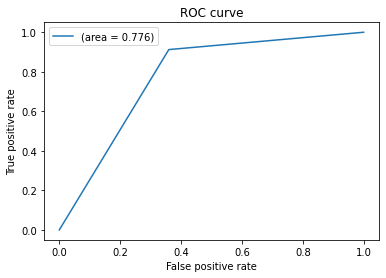

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
tp = tpr_keras
fp = fpr_keras
print(fpr_keras)
print(tpr_keras)



auc_rf = auc(fp, tp)
plt.plot(fp,tp,label="(area = {:.3f})".format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
model1 = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model1.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model1.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.5338153839111328
train loss: 0.062701
train acc: 0.837871


In [ ]:
val_loss, val_acc = model1.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 91.031007
val acc: 0.800491


In [ ]:
pred1 = model1(df_test.values)
print(pred1)

[[0.34547157 0.65452843]
 [0.62728981 0.37271021]
 [0.55249919 0.4475008 ]
 ...
 [0.58358706 0.41641293]
 [0.64153608 0.35846393]
 [0.59880241 0.40119761]]


In [ ]:
tr_pred1 = model1(df_train.values)
print(tr_pred1)

[[ 0.08512633  0.91487372]
 [-0.16157691  1.16157692]
 [ 0.33550833  0.66449167]
 ...
 [-0.08137268  1.08137267]
 [ 0.24419051  0.75580948]
 [ 0.00122944  0.99877055]]


In [ ]:
model2 = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model2.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model2.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.5177173614501953
train loss: 0.063182
train acc: 0.839383


In [ ]:
val_loss, val_acc = model2.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 50.391824
val acc: 0.800491


In [ ]:
pred2 = model2(df_test.values)
print(pred2)

[[0.32214826 0.67785173]
 [0.58684952 0.41315047]
 [0.55107291 0.44892709]
 ...
 [0.56575044 0.43424956]
 [0.71731078 0.28268924]
 [0.56799987 0.43200013]]


In [ ]:
tr_pred2 = model2(df_train.values)
print(tr_pred2)

[[-0.15308417  1.15308413]
 [ 0.13647122  0.8635288 ]
 [ 0.3637994   0.6362006 ]
 ...
 [ 0.11094212  0.88905785]
 [ 0.27182588  0.72817412]
 [ 0.02686308  0.97313694]]


In [ ]:
model3 = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model3.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model3.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.4936368465423584
train loss: 0.063304
train acc: 0.836358


In [ ]:
val_loss, val_acc = model3.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 365.169399
val acc: 0.791897


In [ ]:
pred3 = model3(df_test.values)
print(pred3)

[[0.29754568 0.70245432]
 [0.58994275 0.41005724]
 [0.52342639 0.47657362]
 ...
 [0.62069351 0.37930649]
 [0.5965267  0.40347332]
 [0.56854957 0.43145044]]


In [ ]:
tr_pred3 = model3(df_train.values)
print(tr_pred3)

[[-0.21063234  1.21063229]
 [ 0.19514227  0.80485768]
 [ 0.36478449  0.63521551]
 ...
 [ 0.02396204  0.9760379 ]
 [ 0.26854022  0.73145978]
 [ 0.08465779  0.9153422 ]]


In [ ]:
model4 = ELM(
    input_length,
    num_hidden_layers,
    num_classes
)

Bias shape: (512,)
W shape: (20, 512)
Beta shape: (512, 2)


In [ ]:
model4.fit(df_train.values, y_train1, display_time=True)
train_loss, train_acc = model4.evaluate(df_train.values, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.48693084716796875
train loss: 0.062731
train acc: 0.835451


In [ ]:
val_loss, val_acc = model4.evaluate(df_test.values, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 33.492608
val acc: 0.793738


In [ ]:
pred4 = model4(df_test.values)
print(pred4)

[[0.3201305  0.6798695 ]
 [0.56930537 0.43069463]
 [0.53797771 0.46202228]
 ...
 [0.5368117  0.46318832]
 [0.68563687 0.31436312]
 [0.5674189  0.43258112]]


In [ ]:
tr_pred4 = model4(df_train.values)
print(tr_pred4)

[[-0.11090915  1.11090932]
 [ 0.53191001  0.46809001]
 [ 0.34988858  0.65011142]
 ...
 [-0.10399733  1.10399737]
 [ 0.2419341   0.7580659 ]
 [-0.03550619  1.03550619]]


In [ ]:
train_predictions = []

for i in range(0, len(tr_pred)):
  preds = []
  preds.extend(tr_pred[i])
  preds.extend(tr_pred1[i])
  preds.extend(tr_pred2[i])
  preds.extend(tr_pred3[i])
  preds.extend(tr_pred4[i])
  train_predictions.append(np.array(preds))

In [ ]:
test_predictions = []

for i in range(0, len(pred)):
  preds = []
  preds.extend(pred[i])
  preds.extend(pred1[i])
  preds.extend(pred2[i])
  preds.extend(pred3[i])
  preds.extend(pred4[i])
  test_predictions.append(np.array(preds))


In [ ]:
train_neural = np.array(train_predictions)
print(train_neural.shape)

(3306, 10)


In [ ]:
test_neural = np.array(test_predictions)
print(test_neural.shape)

(1629, 10)


In [ ]:
modelens = ELM(
    10,
    128,
    num_classes
)

Bias shape: (128,)
W shape: (10, 128)
Beta shape: (128, 2)


In [ ]:
modelens.fit(train_neural, y_train1, display_time=True)
train_loss, train_acc = modelens.evaluate(train_neural, y_train1)
print('train loss: %f' % train_loss)
print('train acc: %f' % train_acc)

Train time: 0.08716511726379395
train loss: 0.049702
train acc: 0.864489


In [ ]:
val_loss, val_acc = modelens.evaluate(test_neural, y_test1)
print('val loss: %f' % val_loss)
print('val acc: %f' % val_acc)

val loss: 22584.778456
val acc: 0.808471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, input_dim=10, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(train_neural, np.array(y_train), epochs=200)

Epoch 1/200
104/104 [==============================] - 1s 3ms/step - loss: 0.5516 - accuracy: 0.8264
Epoch 2/200
104/104 [==============================] - 0s 2ms/step - loss: 0.3299 - accuracy: 0.8526
Epoch 3/200
104/104 [==============================] - 0s 3ms/step - loss: 0.3168 - accuracy: 0.8572
Epoch 4/200
104/104 [==============================] - 0s 3ms/step - loss: 0.3253 - accuracy: 0.8621
Epoch 5/200
104/104 [==============================] - 0s 3ms/step - loss: 0.3276 - accuracy: 0.8575
Epoch 6/200
104/104 [==============================] - 0s 3ms/step - loss: 0.3111 - accuracy: 0.8630
Epoch 7/200
104/104 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8618
Epoch 8/200
104/104 [==============================] - 0s 2ms/step - loss: 0.3155 - accuracy: 0.8651
Epoch 9/200
104/104 [==============================] - 0s 2ms/step - loss: 0.3125 - accuracy: 0.8679
Epoch 10/200
104/104 [==============================] - 0s 2ms/step - loss: 0.3173 - accura

In [ ]:
_, accuracy = model.evaluate(test_neural, np.array(y_test))
print(accuracy)

51/51 [==============================] - 0s 1ms/step - loss: 48.2781 - accuracy: 0.8250
0.8250460624694824


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaClassifier = AdaBoostClassifier(n_estimators=200)
adaClassifier.fit(train_neural, np.array(y_train))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=None)

In [ ]:
predictions = dtClassifier.predict(test_neural)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
matrix = confusion_matrix(np.array(y_test), predictions)
print(matrix)
score = accuracy_score(np.array(y_test), predictions)
print(score)
report = classification_report(np.array(y_test), predictions)
print(report)

[[415 188]
 [168 858]]
0.7814610190300798
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       603
           1       0.82      0.84      0.83      1026

    accuracy                           0.78      1629
   macro avg       0.77      0.76      0.76      1629
weighted avg       0.78      0.78      0.78      1629



In [ ]:
print(df_train)

      Open Price  High Price  ...  Ch(t)- Close Price  SMA Close Price
1765    0.281915    0.281751  ...            0.000337         0.234446
2317    0.117908    0.125585  ...           -0.000219         0.164808
3567    0.006752    0.006747  ...            0.000525         0.003580
910     0.059929    0.061765  ...            0.001199         0.014798
124     0.031489    0.034692  ...            0.001226         0.043890
...          ...         ...  ...                 ...              ...
4426    0.015390    0.018675  ...            0.004878         0.007611
466     0.001312    0.001311  ...           -0.003684         0.001158
3092    0.403901    0.403969  ...           -0.000826         0.471283
3772    0.027021    0.027073  ...           -0.000971         0.020168
860     0.036099    0.036215  ...            0.001169         0.009318

[3306 rows x 20 columns]


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_train.iloc[:,0:19],y_train)

ValueError: ignored